<a href="https://colab.research.google.com/github/yblainm/comp550project/blob/master/CNN_Literary_Subjectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import os,sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
ROOT_PATH = os.path.join("drive","My Drive","COMP 550 Final Project")

In [196]:
import pickle
import pandas as pd
import numpy as np
import nltk.tokenize
nltk.download('punkt')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from sklearn.pipeline import Pipeline, make_pipeline
# from scipy.sparse import csr_matrix, vstack, hstack
# from keras.preprocessing.text import Tokenizer

sklearn.__version__

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'0.19.2'

In [4]:
import keras
from keras.constraints import MaxNorm
from keras.layers import Activation, concatenate, Dense, Dropout, Embedding, Flatten, GlobalMaxPool1D, Input, Permute, ZeroPadding2D
from keras.layers.convolutional import Conv1D
from keras.models import Model
from keras.initializers import RandomUniform, Constant
from keras.regularizers import l2
from keras.optimizers import adadelta
from keras import backend as K
keras.__version__

Using TensorFlow backend.


'2.2.4'

### Get and Save GloVe for Subj-Subj

In [0]:
glove = get_embeddings(enc.label_enc.classes_, enc.label_enc)

In [0]:
with open(os.path.join(ROOT_PATH,"glove_subj_npy.pickle"), 'wb') as f:
    pickle.dump(obj=glove, file=f)

### Load GloVe from Drive

In [0]:
with open(os.path.join(ROOT_PATH,"glove_subj_npy.pickle"), 'rb') as f:
    glove = pickle.load(f)

## Getting sentences and paragraphs

In [0]:
austen = pd.read_csv(os.path.join(ROOT_PATH, "tokens", "austen.sense.tokens"), sep='\t', quoting=3)

In [0]:
austen_sent_gp = austen.groupby('sentenceID')

In [0]:
austen_sentences = [" ".join(austen_sent_gp.get_group(i)['originalWord']).lower() for i in austen['sentenceID'].unique()]

In [0]:
austen_sentences

5090

In [0]:
austen_para_gp = austen.groupby('paragraphId')

In [0]:
austen_paragraphs = [" ".join(austen_para_gp.get_group(i)['originalWord']).lower() for i in austen['paragraphId'].unique()]

In [0]:
austen_paragraphs

1865

In [0]:
with open(os.path.join(ROOT_PATH, 'austen_sentences.txt'), 'w+') as f:
    f.write('\n'.join(austen_sentences))
    f.close()

In [0]:
with open(os.path.join(ROOT_PATH, 'austen_paragraphs.txt'), 'w+') as f:
    f.write('\n'.join(austen_paragraphs))
    f.close()

## Function/class definitions

In [0]:
minibatchsize = 50


def getCNNRand(vocabsize, maxlength, ordinal=False, classnum=2, embedding_dim=300,
               embedding_range=0.05, embedding_matrix=None, filters=[3,4,5], map_size=100,
               act_fct='relu', constr=3, dropprob=0.5,optim="adadelta"):
    
    inputs = Input(shape=(maxlength,), dtype='int32')
    embedding = Embedding(input_dim=vocabsize, output_dim=embedding_dim,
                          embeddings_initializer=RandomUniform(
                              seed=69,minval=embedding_range,maxval=embedding_range)
                          if embedding_matrix is None else Constant(value=embedding_matrix),
                          mask_zero=False, input_length=maxlength)(inputs)
    # I want mask_zero to be true (?), but Keras doesn't support it.
    # Perhaps temporal pooling makes this unimportant?

    convs = []

    for i in range(0,len(filters)):
        conv=Conv1D(filters=map_size, kernel_size=filters[i],
                    activation=act_fct, padding="valid")(embedding)

        pool=GlobalMaxPool1D()(conv)

        convs.append(pool)
        
    concat = concatenate(convs)
    
    if ordinal:
        classes = Dense(units=1, kernel_constraint=constr)(concat)
        dropout = Dropout(dropprob)(classes)
#         act = Activation('exponential')(dropout)
        act = Activation('sigmoid')(dropout)
        model = Model(inputs=inputs, outputs=act)
        model.compile(optimizer=optim, loss="mse", metrics=['accuracy'])
    else:
        classes = Dense(units=classnum, kernel_constraint=MaxNorm(constr))(concat)
        dropout = Dropout(dropprob)(classes)
        act = Activation('softmax')(dropout)
        model = Model(inputs=inputs, outputs=act)
        model.compile(optimizer=optim, loss="categorical_crossentropy", metrics=['accuracy'])
    
    return model

In [0]:
class Encoder:
    def __init__(self):
        self.max_len = None
        self.vocab_len = None
        self.label_enc = None
        self.pad_idx = None
        self.pad_token = "_<PAD>_"
        
    def fit_vocab(self, document_tokens):
        self.max_len = len(max(document_tokens, key=lambda x: len(x)))
        fit_list = list(set([token for l in document_tokens for token in l]))
        fit_list.append(self.pad_token)
        self.vocab_len = len(fit_list)
        
        self.label_enc = LabelEncoder()
        vocab_labels = self.label_enc.fit(fit_list)
#         self.label_enc.classes_ = np.hstack(([self.pad_token],(enc.label_enc.classes_)))
        self.pad_idx = self.label_enc.transform([[self.pad_token]])[0]
        
    def transform(self, document_tokens):
        return np.concatenate(document_tokens.apply(lambda x: self.pad_sentence_array(self.label_enc.transform(x))).values).reshape(len(document_tokens),-1)
    
    def pad_sentence_array(self, sentence_array):
        return np.append(sentence_array, np.repeat(self.pad_idx,self.max_len-len(sentence_array)))
        

In [0]:
def prepare_data(df):
    data = {}
    data['all'] = {}
    data['all']['x'] = df[0].copy()
    data['all']['y'] = df[1].copy()
    data['x'] = {}
    data['y'] = {}
    train, test = train_test_split(df, train_size=0.8)
    val, test = train_test_split(test, train_size=0.5)
    data['x']['train'] = train[0]
    data['y']['train'] = train[1]
    data['x']['val'] = val[0]
    data['y']['val'] = val[1]
    data['x']['test'] = test[0]
    data['y']['test'] = test[1]
    return data

In [0]:
def get_embeddings(vocab_list, labelencoder, embedding_dim=300, emb_path=os.path.join(ROOT_PATH, "glove.6B.300d.txt")):
    embedding_matrix = np.zeros((len(vocab_list), embedding_dim))
    with open(emb_path, 'r') as f:
        for line in f:
            vals = line.split()
            word = vals[0]
            weight = np.array(vals[1:], dtype='float32')
            if word in vocab_list:
                embedding_matrix[labelencoder.transform([word])[0]] = weight
    return embedding_matrix

## Subj-Subj (and Hyperparam. search)

### Load Subj data

In [0]:
with open(os.path.join(ROOT_PATH,"Subj","obj.p"), 'rb') as f:
    subj_obj = pickle.load(f, encoding='latin1')
    f.close()
with open(os.path.join(ROOT_PATH,"Subj","subj.p"), 'rb') as f:
    subj_subj = pickle.load(f, encoding='latin1')
    f.close()

In [10]:
data_subj = prepare_data(pd.DataFrame({0:subj_obj, 1:0}).append(
    pd.DataFrame({0:subj_subj, 1:1})))
labelenc = OneHotEncoder()

enc = Encoder()
enc.fit_vocab(data_subj['all']['x'])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
subj_y_train = labelenc.fit_transform(data_subj['y']['train'].values.reshape(-1,1))
subj_y_val = labelenc.transform(data_subj['y']['val'].values.reshape(-1,1))
subj_y_test = labelenc.transform(data_subj['y']['test'].values.reshape(-1,1))
subj_x_train = enc.transform(data_subj['x']['train'])
subj_x_val = enc.transform(data_subj['x']['val'])
subj_x_test = enc.transform(data_subj['x']['test'])

### Preliminary test on Subj-Subj

In [0]:
model_subjsubj = getCNNRand(vocabsize=enc.vocab_len, maxlength=enc.max_len,
                            filters=(3,6,9), embedding_matrix=glove)

In [0]:
model_subjsubj.fit(subj_x_train, subj_y_train,batch_size=256,
                   epochs=5,validation_data=(subj_x_val,subj_y_val),verbose=1)

### Hyperparameter search (no GloVe)

In [13]:
import gc

164

In [25]:
K.clear_session()
gc.collect()

103

In [0]:
# https://stackoverflow.com/a/40623158
import itertools

def dict_product(dicts):
    return (dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))

In [0]:
# getCNNRand(vocabsize, maxlength, ordinal=False, classnum=2, embedding_dim=300,
#                embedding_range=0.05, filters=[3,4,5], map_size=100,
#                act_fct='relu', constr=MaxNorm(3), optim="adadelta")

hyperparams = {'filters' : [(1,2,3),(2,4,6),(1,4,8),(1,2,3,4,5),(3,6,10)], 'map_size' : [20, 50, 100, 200],
               'constr':[0.5, 3, 10],
              'dropprob':[0.25, 0.5, 0.9]}
all_params = [params for params in dict_product(hyperparams)]

In [26]:
validation = {}

for params in all_params:
    model = getCNNRand(enc.vocab_len, enc.max_len, classnum=2, optim="adam", **params)
    history = model.fit(subj_x_train,subj_y_train,batch_size=256,epochs=5,validation_data=(subj_x_val,subj_y_val),verbose=1)
    validation[tuple((k,v) for k,v in params.items())] = history.history['acc']
    del model
    K.clear_session()
    for i in range(3): gc.collect()

Train on 8000 samples, validate on 1000 samples
Epoch 1/5
8000/8000 [==============================] - 2s 271us/step - loss: 0.6704 - acc: 0.6730 - val_loss: 0.6217 - val_acc: 0.8270
Epoch 2/5
8000/8000 [==============================] - 1s 135us/step - loss: 0.5297 - acc: 0.8423 - val_loss: 0.4343 - val_acc: 0.8530
Epoch 3/5
8000/8000 [==============================] - 1s 137us/step - loss: 0.3645 - acc: 0.8665 - val_loss: 0.3352 - val_acc: 0.8700
Epoch 4/5
8000/8000 [==============================] - 1s 136us/step - loss: 0.2647 - acc: 0.8984 - val_loss: 0.2923 - val_acc: 0.8790
Epoch 5/5
8000/8000 [==============================] - 1s 136us/step - loss: 0.1994 - acc: 0.9297 - val_loss: 0.2689 - val_acc: 0.8820
Train on 8000 samples, validate on 1000 samples
Epoch 1/5
8000/8000 [==============================] - 2s 257us/step - loss: 0.6752 - acc: 0.6082 - val_loss: 0.6379 - val_acc: 0.8360
Epoch 2/5
8000/8000 [==============================] - 1s 137us/step - loss: 0.5804 - acc: 0.7

In [0]:
validation

In [0]:
# Save validation after runtime memory
with open(os.path.join(ROOT_PATH, "validation_partial.pickle"), 'wb') as f:
    pickle.dump(validation, f)
    f.close()

In [0]:
# Load validation
with open(os.path.join(ROOT_PATH, "validation_partial.pickle"), 'r') as f:
    validation = pickle.load(f)
    f.close()

In [29]:
all_params[len(validation)] # Which one failed?

180

In [0]:
for params in all_params[len(validation):]:
    model = getCNNRand(enc.vocab_len, enc.max_len, classnum=2, optim="adam", **params)
    history = model.fit(subj_x_train,subj_y_train,batch_size=256,epochs=5,validation_data=(subj_x_val,subj_y_val),verbose=1)
    validation[tuple((k,v) for k,v in params.items())] = history.history['acc']
    K.clear_session()
    gc.collect()

In [0]:
best_params = max(validation.keys(), key=lambda x: validation.get(x)[-1])

In [31]:
best_params

(('filters', (3, 6, 10)), ('map_size', 200), ('constr', 3), ('dropprob', 0.25))

In [0]:
with open(os.path.join(ROOT_PATH, "best_params_tuple.pickle"), 'wb') as f:
    pickle.dump(best_params, f)
    f.close()

## Load Subj-Austen data

In [0]:
labeled_austen = pd.read_csv(os.path.join(ROOT_PATH,"theogfanficwriter.txt"), sep='\t', header=None)

In [0]:
labeled_austen = labeled_austen[pd.notna(labeled_austen[1])]

In [0]:
labeled_austen[0] = labeled_austen[0].apply(nltk.tokenize.word_tokenize)

In [146]:
austen_data = prepare_data(labeled_austen)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [255]:
labelenc = OneHotEncoder()
labelenc.fit(austen_data['all']['y'].append(data_subj['all']['y']).values.reshape(-1,1))
austen_y = labelenc.transform(austen_data['all']['y'].values.reshape(-1,1))
subj_y = labelenc.transform(data_subj['all']['y'].values.reshape(-1,1))

enc = Encoder()
enc.fit_vocab(austen_data['all']['x'].append(data_subj['all']['x']))

austen_x = enc.transform(austen_data['all']['x'])
subj_x = enc.transform(data_subj['all']['x'])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Experiments using best hyperparams

In [0]:
# Load best hyperparams
with open(os.path.join(ROOT_PATH, "best_params_tuple.pickle"), 'r') as f:
    best_params = pickle.load(f)
    f.close()

## Subj-Subj

### No GloVe

In [0]:
model_subjsubj = getCNNRand(enc.vocab_len, enc.max_len, classnum=2, **dict((k,v) for k,v in best_params))

In [85]:
model_subjsubj.fit(subj_x_train,subj_y_train,batch_size=50,epochs=15,
                   validation_data=(subj_x_val,subj_y_val),verbose=1)

Train on 8000 samples, validate on 1000 samples
Epoch 1/15
8000/8000 [==============================] - 7s 878us/step - loss: 0.0521 - acc: 0.9703 - val_loss: 0.3743 - val_acc: 0.9010
Epoch 2/15
8000/8000 [==============================] - 7s 864us/step - loss: 0.0492 - acc: 0.9704 - val_loss: 0.3964 - val_acc: 0.9010
Epoch 3/15
8000/8000 [==============================] - 7s 870us/step - loss: 0.0486 - acc: 0.9713 - val_loss: 0.4158 - val_acc: 0.8940
Epoch 4/15
8000/8000 [==============================] - 7s 868us/step - loss: 0.0478 - acc: 0.9673 - val_loss: 0.3984 - val_acc: 0.9030
Epoch 5/15
8000/8000 [==============================] - 7s 862us/step - loss: 0.0464 - acc: 0.9695 - val_loss: 0.4148 - val_acc: 0.8990
Epoch 6/15
8000/8000 [==============================] - 7s 868us/step - loss: 0.0448 - acc: 0.9715 - val_loss: 0.4286 - val_acc: 0.8980
Epoch 7/15
8000/8000 [==============================] - 7s 865us/step - loss: 0.0450 - acc: 0.9704 - val_loss: 0.4256 - val_acc: 0.8990


In [86]:
model_subjsubj.evaluate(subj_x_test, subj_y_test)

1000/1000 [==============================] - 0s 247us/step


[0.3267310016490519, 0.918]

### With GloVe

In [0]:
model_subjsubj = getCNNRand(enc.vocab_len, enc.max_len, classnum=2, embedding_matrix=glove, **dict((k,v) for k,v in best_params))

In [67]:
model_subjsubj.fit(subj_x_train,subj_y_train,batch_size=50,epochs=10,
                   validation_data=(subj_x_val,subj_y_val),verbose=1)

Train on 8000 samples, validate on 1000 samples
Epoch 1/10
8000/8000 [==============================] - 9s 1ms/step - loss: 0.4207 - acc: 0.8286 - val_loss: 0.1832 - val_acc: 0.9320
Epoch 2/10
8000/8000 [==============================] - 7s 870us/step - loss: 0.2215 - acc: 0.9075 - val_loss: 0.1937 - val_acc: 0.9130
Epoch 3/10
8000/8000 [==============================] - 7s 876us/step - loss: 0.1232 - acc: 0.9431 - val_loss: 0.1688 - val_acc: 0.9400
Epoch 4/10
8000/8000 [==============================] - 7s 867us/step - loss: 0.0797 - acc: 0.9606 - val_loss: 0.1953 - val_acc: 0.9310
Epoch 5/10
8000/8000 [==============================] - 7s 869us/step - loss: 0.0682 - acc: 0.9590 - val_loss: 0.1887 - val_acc: 0.9370
Epoch 6/10
8000/8000 [==============================] - 7s 869us/step - loss: 0.0526 - acc: 0.9680 - val_loss: 0.2118 - val_acc: 0.9340
Epoch 7/10
8000/8000 [==============================] - 7s 872us/step - loss: 0.0467 - acc: 0.9697 - val_loss: 0.2323 - val_acc: 0.9370
Ep

In [68]:
model_subjsubj.evaluate(subj_x_test, subj_y_test)

1000/1000 [==============================] - 0s 251us/step


[0.22989227090775965, 0.931]

In [69]:
model_subjsubj.fit(subj_x_train,subj_y_train,batch_size=50,epochs=10,
                   validation_data=(subj_x_val,subj_y_val),verbose=1)

Train on 8000 samples, validate on 1000 samples
Epoch 1/10
8000/8000 [==============================] - 7s 865us/step - loss: 0.0450 - acc: 0.9686 - val_loss: 0.2909 - val_acc: 0.9370
Epoch 2/10
8000/8000 [==============================] - 7s 869us/step - loss: 0.0443 - acc: 0.9692 - val_loss: 0.2984 - val_acc: 0.9380
Epoch 3/10
8000/8000 [==============================] - 7s 880us/step - loss: 0.0446 - acc: 0.9666 - val_loss: 0.3040 - val_acc: 0.9370
Epoch 4/10
8000/8000 [==============================] - 7s 876us/step - loss: 0.0450 - acc: 0.9695 - val_loss: 0.3115 - val_acc: 0.9390
Epoch 5/10
8000/8000 [==============================] - 7s 874us/step - loss: 0.0442 - acc: 0.9678 - val_loss: 0.3155 - val_acc: 0.9370
Epoch 6/10
8000/8000 [==============================] - 7s 869us/step - loss: 0.0399 - acc: 0.9725 - val_loss: 0.3198 - val_acc: 0.9390
Epoch 7/10
8000/8000 [==============================] - 7s 865us/step - loss: 0.0420 - acc: 0.9690 - val_loss: 0.3235 - val_acc: 0.9370


In [70]:
model_subjsubj.evaluate(subj_x_test, subj_y_test)

1000/1000 [==============================] - 0s 249us/step


[0.2768380113132298, 0.927]

## Subj-Austen

### No GloVe

In [0]:
model_subjaust = getCNNRand(enc.vocab_len, enc.max_len, classnum=2, **dict((k,v) for k,v in best_params))

In [227]:
history = model_subjaust.fit(subj_x,subj_y,batch_size=50,epochs=50,validation_data=(austen_x, austen_y),verbose=1)

Train on 10000 samples, validate on 699 samples
Epoch 1/50
10000/10000 [==============================] - 12s 1ms/step - loss: 0.5898 - acc: 0.6772 - val_loss: 0.8903 - val_acc: 0.5007
Epoch 2/50
10000/10000 [==============================] - 9s 877us/step - loss: 0.4316 - acc: 0.8020 - val_loss: 0.9287 - val_acc: 0.5465
Epoch 3/50
10000/10000 [==============================] - 9s 872us/step - loss: 0.3549 - acc: 0.8428 - val_loss: 1.1550 - val_acc: 0.5336
Epoch 4/50
10000/10000 [==============================] - 9s 878us/step - loss: 0.2934 - acc: 0.8733 - val_loss: 1.0153 - val_acc: 0.5837
Epoch 5/50
10000/10000 [==============================] - 9s 887us/step - loss: 0.2426 - acc: 0.8994 - val_loss: 1.0073 - val_acc: 0.5980
Epoch 6/50
10000/10000 [==============================] - 9s 884us/step - loss: 0.1989 - acc: 0.9142 - val_loss: 1.4627 - val_acc: 0.5665
Epoch 7/50
10000/10000 [==============================] - 9s 878us/step - loss: 0.1658 - acc: 0.9289 - val_loss: 1.3756 - val

In [228]:
model_subjaust.evaluate(austen_x, austen_y)

699/699 [==============================] - 0s 265us/step


[3.3696964609094273, 0.58369098755082]

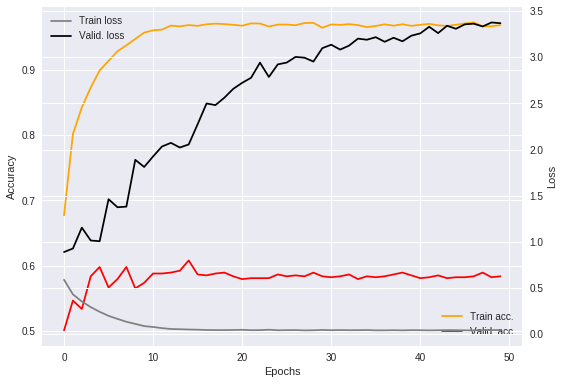

In [229]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.plot(history.history['acc'], color='orange', label="Train acc.")
ax1.plot(history.history['val_acc'], color='red', label="Valid. acc")
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('Loss')
ax2.plot(history.history['loss'], color='gray', label="Train loss")
ax2.plot(history.history['val_loss'], color='black', label="Valid. loss")
ax2.legend()

fig.tight_layout()
plt.show()

### With GloVe

In [0]:
model_subjaust = getCNNRand(enc.vocab_len, enc.max_len, classnum=2, embedding_matrix=glove, **dict((k,v) for k,v in best_params))

In [218]:
model_subjaust.fit(subj_x,subj_y,batch_size=50,epochs=50,validation_data=(austen_x, austen_y),verbose=1)

Train on 10000 samples, validate on 699 samples
Epoch 1/50
10000/10000 [==============================] - 13s 1ms/step - loss: 0.5549 - acc: 0.7405 - val_loss: 1.0629 - val_acc: 0.5422
Epoch 2/50
10000/10000 [==============================] - 9s 877us/step - loss: 0.2644 - acc: 0.8875 - val_loss: 1.3599 - val_acc: 0.5408
Epoch 3/50
10000/10000 [==============================] - 9s 879us/step - loss: 0.1385 - acc: 0.9430 - val_loss: 1.2720 - val_acc: 0.5694
Epoch 4/50
10000/10000 [==============================] - 9s 871us/step - loss: 0.0825 - acc: 0.9593 - val_loss: 1.9889 - val_acc: 0.5393
Epoch 5/50
10000/10000 [==============================] - 9s 874us/step - loss: 0.0559 - acc: 0.9698 - val_loss: 1.9466 - val_acc: 0.5665
Epoch 6/50
10000/10000 [==============================] - 9s 875us/step - loss: 0.0483 - acc: 0.9679 - val_loss: 2.2818 - val_acc: 0.5737
Epoch 7/50
10000/10000 [==============================] - 9s 875us/step - loss: 0.0448 - acc: 0.9711 - val_loss: 2.5692 - val

In [219]:
model_subjaust.evaluate(austen_x, austen_y)

699/699 [==============================] - 0s 244us/step


[3.5215626301854126, 0.5836909866981069]

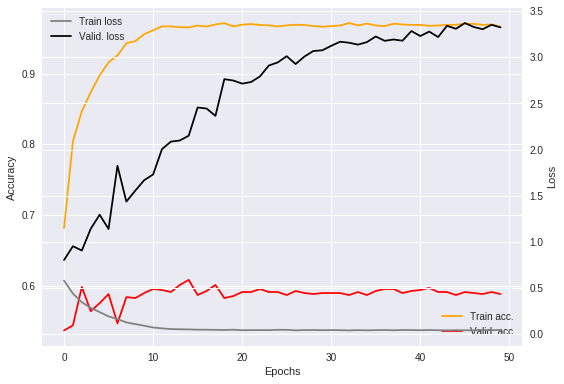

In [225]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.plot(history.history['acc'], color='orange', label="Train acc.")
ax1.plot(history.history['val_acc'], color='red', label="Valid. acc")
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('Loss')
ax2.plot(history.history['loss'], color='gray', label="Train loss")
ax2.plot(history.history['val_loss'], color='black', label="Valid. loss")
ax2.legend()

fig.tight_layout()
plt.show()

## Austen-Austen

### No GloVe

In [0]:
# labelenc = OneHotEncoder()
# labelenc.fit(austen_data['all']['y'].values.reshape(-1,1))
austen_y_train = labelenc.transform(austen_data['y']['train'].values.reshape(-1,1))
austen_y_test = labelenc.transform(austen_data['y']['test'].append(austen_data['y']['val']).values.reshape(-1,1))

# enc = Encoder()
# enc.fit_vocab(austen_data['all']['x'])
austen_x_train = enc.transform(austen_data['x']['train'])
austen_x_test = enc.transform(austen_data['x']['test'].append(austen_data['x']['val']))

In [0]:
model_subjaust = getCNNRand(enc.vocab_len, enc.max_len, classnum=2, **dict((k,v) for k,v in best_params))

In [0]:
history = model_subjaust.fit(austen_x_train,austen_y_train,batch_size=1,epochs=25,validation_data=(austen_x_test, austen_y_test),verbose=1)

In [248]:
model_subjaust.evaluate(austen_x_test, austen_y_test)

140/140 [==============================] - 0s 386us/step


[1.8732414518083844, 0.7142857125827244]

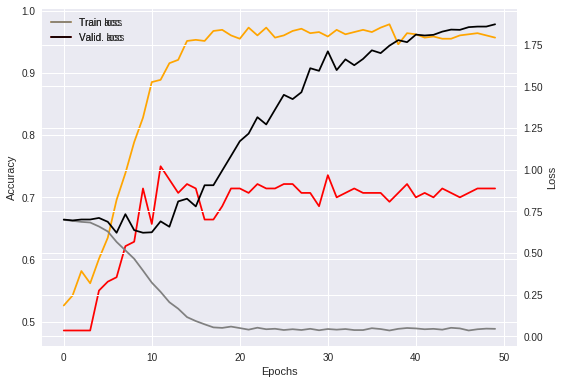

In [249]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.plot(history.history['acc'], color='orange', label="Train acc.")
ax1.plot(history.history['val_acc'], color='red', label="Valid. acc")
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('Loss')
ax2.plot(history.history['loss'], color='gray', label="Train loss")
ax2.plot(history.history['val_loss'], color='black', label="Valid. loss")
ax2.legend()

fig.tight_layout()
plt.show()

### With GloVe

In [0]:
model_subjaust = getCNNRand(enc.vocab_len, enc.max_len, classnum=2, embedding_matrix=glove, **dict((k,v) for k,v in best_params))

In [291]:
history = model_subjaust.fit(austen_x_train,austen_y_train,batch_size=1,epochs=25,validation_data=(austen_x_test, austen_y_test),verbose=1)

Train on 559 samples, validate on 140 samples
Epoch 1/25
559/559 [==============================] - 19s 34ms/step - loss: 1.2536 - acc: 0.5420 - val_loss: 1.1155 - val_acc: 0.5500
Epoch 2/25
559/559 [==============================] - 13s 22ms/step - loss: 0.4521 - acc: 0.7961 - val_loss: 0.8686 - val_acc: 0.6071
Epoch 3/25
559/559 [==============================] - 13s 23ms/step - loss: 0.2427 - acc: 0.8873 - val_loss: 1.0753 - val_acc: 0.6000
Epoch 4/25
559/559 [==============================] - 13s 23ms/step - loss: 0.1256 - acc: 0.9302 - val_loss: 1.2264 - val_acc: 0.6286
Epoch 5/25
559/559 [==============================] - 13s 23ms/step - loss: 0.0899 - acc: 0.9463 - val_loss: 0.9550 - val_acc: 0.6857
Epoch 6/25
559/559 [==============================] - 12s 22ms/step - loss: 0.0636 - acc: 0.9553 - val_loss: 1.4329 - val_acc: 0.5929
Epoch 7/25
559/559 [==============================] - 12s 22ms/step - loss: 0.0694 - acc: 0.9481 - val_loss: 1.0307 - val_acc: 0.6714
Epoch 8/25
559/5

In [292]:
model_subjaust.evaluate(austen_x_test, austen_y_test)

140/140 [==============================] - 0s 403us/step


[1.707511820111956, 0.7071428554398673]

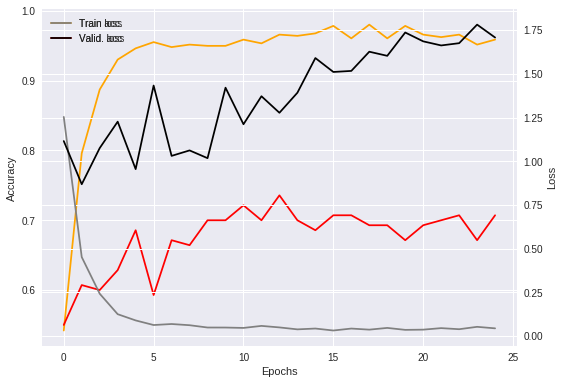

In [293]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.plot(history.history['acc'], color='orange', label="Train acc.")
ax1.plot(history.history['val_acc'], color='red', label="Valid. acc")
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('Loss')
ax2.plot(history.history['loss'], color='gray', label="Train loss")
ax2.plot(history.history['val_loss'], color='black', label="Valid. loss")
ax2.legend()

fig.tight_layout()
plt.show()

## Mixed-Austen

### No GloVe

In [0]:
# labelenc = OneHotEncoder()
# labelenc.fit(austen_data['all']['y'].values.reshape(-1,1))
mixed_y = labelenc.transform(austen_data['y']['train'].append(data_subj['y']['val']).append(data_subj['y']['test']).values.reshape(-1,1))
austen_y_test = labelenc.transform(austen_data['y']['test'].append(austen_data['y']['val']).values.reshape(-1,1))

# enc = Encoder()
# enc.fit_vocab(austen_data['all']['x'])
mixed_x = enc.transform(austen_data['x']['train'].append(data_subj['x']['val']).append(data_subj['x']['test']))

In [0]:
model_subjaust = getCNNRand(enc.vocab_len, enc.max_len, classnum=2, **dict((k,v) for k,v in best_params))

In [311]:
history = model_subjaust.fit(mixed_x,mixed_y,batch_size=50,epochs=25,validation_data=(austen_x_test, austen_y_test),verbose=1)

Train on 2559 samples, validate on 140 samples
Epoch 1/25
2559/2559 [==============================] - 7s 3ms/step - loss: 0.6986 - acc: 0.5049 - val_loss: 0.7060 - val_acc: 0.4857
Epoch 2/25
2559/2559 [==============================] - 2s 875us/step - loss: 0.6716 - acc: 0.5905 - val_loss: 0.6701 - val_acc: 0.5929
Epoch 3/25
2559/2559 [==============================] - 2s 875us/step - loss: 0.6155 - acc: 0.6667 - val_loss: 0.7388 - val_acc: 0.5571
Epoch 4/25
2559/2559 [==============================] - 2s 870us/step - loss: 0.5702 - acc: 0.7065 - val_loss: 0.7350 - val_acc: 0.6143
Epoch 5/25
2559/2559 [==============================] - 2s 868us/step - loss: 0.5196 - acc: 0.7397 - val_loss: 0.9066 - val_acc: 0.5429
Epoch 6/25
2559/2559 [==============================] - 2s 868us/step - loss: 0.4820 - acc: 0.7628 - val_loss: 0.7117 - val_acc: 0.6143
Epoch 7/25
2559/2559 [==============================] - 2s 861us/step - loss: 0.4413 - acc: 0.7968 - val_loss: 0.7247 - val_acc: 0.6286
Epo

In [312]:
model_subjaust.evaluate(austen_x_test, austen_y_test)

140/140 [==============================] - 0s 292us/step


[1.2179525920322962, 0.7214285705770765]

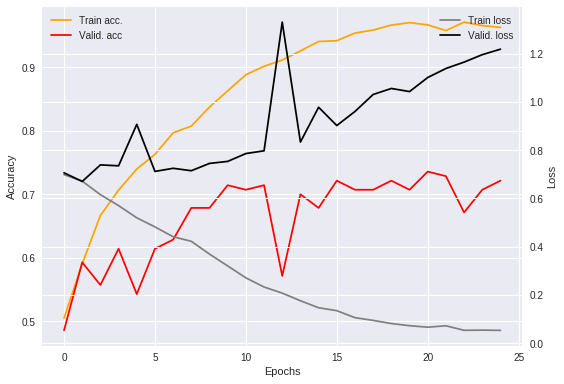

In [313]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.plot(history.history['acc'], color='orange', label="Train acc.")
ax1.plot(history.history['val_acc'], color='red', label="Valid. acc")
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('Loss')
ax2.plot(history.history['loss'], color='gray', label="Train loss")
ax2.plot(history.history['val_loss'], color='black', label="Valid. loss")
ax2.legend()

fig.tight_layout()
plt.show()

### With GloVe

In [0]:
model_subjaust = getCNNRand(enc.vocab_len, enc.max_len, classnum=2, embedding_matrix=glove, **dict((k,v) for k,v in best_params))

In [315]:
history = model_subjaust.fit(mixed_x,mixed_y,batch_size=50,epochs=25,validation_data=(austen_x_test, austen_y_test),verbose=1)

Train on 2559 samples, validate on 140 samples
Epoch 1/25
2559/2559 [==============================] - 7s 3ms/step - loss: 0.8436 - acc: 0.6069 - val_loss: 1.3447 - val_acc: 0.5000
Epoch 2/25
2559/2559 [==============================] - 2s 865us/step - loss: 0.3175 - acc: 0.8574 - val_loss: 0.7458 - val_acc: 0.6000
Epoch 3/25
2559/2559 [==============================] - 2s 867us/step - loss: 0.1777 - acc: 0.9347 - val_loss: 0.6958 - val_acc: 0.6071
Epoch 4/25
2559/2559 [==============================] - 2s 864us/step - loss: 0.1240 - acc: 0.9601 - val_loss: 0.7466 - val_acc: 0.6000
Epoch 5/25
2559/2559 [==============================] - 2s 864us/step - loss: 0.0894 - acc: 0.9637 - val_loss: 0.7382 - val_acc: 0.6214
Epoch 6/25
2559/2559 [==============================] - 2s 865us/step - loss: 0.0736 - acc: 0.9687 - val_loss: 0.7879 - val_acc: 0.5929
Epoch 7/25
2559/2559 [==============================] - 2s 872us/step - loss: 0.0654 - acc: 0.9672 - val_loss: 0.8497 - val_acc: 0.6000
Epo

In [316]:
model_subjaust.evaluate(austen_x_test, austen_y_test)

140/140 [==============================] - 0s 318us/step


[1.2938524246215821, 0.6071428562913622]

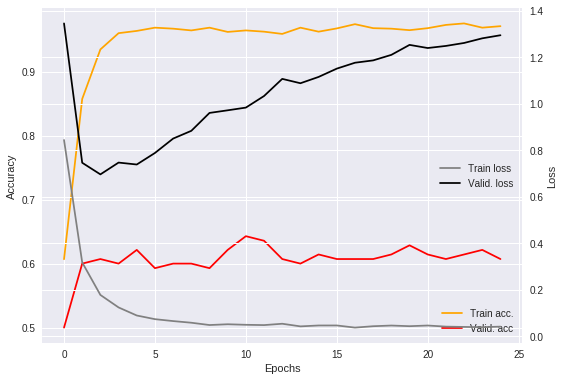

In [317]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.plot(history.history['acc'], color='orange', label="Train acc.")
ax1.plot(history.history['val_acc'], color='red', label="Valid. acc")
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('Loss')
ax2.plot(history.history['loss'], color='gray', label="Train loss")
ax2.plot(history.history['val_loss'], color='black', label="Valid. loss")
ax2.legend()

fig.tight_layout()
plt.show()